In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

/home/alison/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_DIR = 'data/kaggle_dogcat'
CATEGORIES = ['cat', 'dog']
IMG_SCALE = 5
IMG_W = IMG_H = 32 * IMG_SCALE
IMG_CHANNELS = 3
IMG_SIZE = (IMG_W, IMG_H)

data = []
for c in CATEGORIES:
    c_dir = c + 's'
    for f in os.listdir(os.path.join(DATA_DIR, 'train', c_dir)):
        data.append((os.path.join(c_dir, f), c))
df = pd.DataFrame(data, columns=['filename', 'category'])
df['category'].value_counts()

dog    2000
cat    2000
Name: category, dtype: int64

In [3]:
df_test = pd.DataFrame({'filename': sorted(os.listdir(os.path.join(DATA_DIR, 'test')))})
df_test.count()

filename    400
dtype: int64

In [4]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=1)
df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
print('df_train:\n', df_train['category'].value_counts())
print('df_val:\n', df_val['category'].value_counts())

df_train:
 dog    1807
cat    1793
Name: category, dtype: int64
df_val:
 cat    207
dog    193
Name: category, dtype: int64


In [5]:
def plot_train_history(exps, epochs):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.set_title('Loss')
    ax1.set_xticks(np.arange(1, epochs, 1))
    ax1.set_yticks(np.arange(0, 1, 0.1))
    
    ax2.set_title('Acc')
    ax2.set_xticks(np.arange(1, epochs, 1))
    
    for i, (exp, history) in enumerate(exps.items()):
        c = color_bar[i]
        ax1.plot(history.history['loss'], color=c, label=exp)
        ax1.plot(history.history['val_loss'], color=c, label=exp, linestyle='--')
        ax2.plot(history.history['acc'], color=c, label=exp)
        ax2.plot(history.history['val_acc'], color=c, label=exp, linestyle='--')

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

def make_validation(y_valid, y_pred, category_index):
    auc_score = roc_auc_score(y_true=y_valid, y_score=y_pred[:, category_index])
    acc = accuracy_score(y_true=y_valid, y_pred=y_pred.argmax(axis=1))
    print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

In [6]:
def get_train_gen(df_train, batch_size):
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    train_gen = train_datagen.flow_from_dataframe(
        df_train, 
        os.path.join(DATA_DIR, 'train'), 
        x_col='filename',
        y_col='category',
        target_size=IMG_SIZE,
        class_mode='categorical',
        classes=CATEGORIES,
        batch_size=batch_size
    )
    return train_gen

def get_val_gen(df_val, batch_size):
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_gen = val_datagen.flow_from_dataframe(
        df_val, 
        os.path.join(DATA_DIR, 'train'), 
        x_col='filename',
        y_col='category',
        target_size=IMG_SIZE,
        class_mode='categorical',
        classes=CATEGORIES,
        batch_size=batch_size
    )
    return val_gen

def get_test_gen(df_test, batch_size):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_dataframe(
        df_test, 
        os.path.join(DATA_DIR, 'test'), 
        x_col='filename',
        y_col=None,
        class_mode=None,
        target_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=False
    )
    return test_gen

In [7]:
def train(EPOCHS, ALPHA, H5FILE, BATCH_SIZE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    base_model = MobileNetV2(
        input_shape=(IMG_W, IMG_H, IMG_CHANNELS),
        alpha=ALPHA,
        include_top=False
    )
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    preds = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=preds)
    
    model.compile(loss='categorical_crossentropy',
#                   optimizer=Adam(),
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(H5FILE, monitor='val_acc', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=1e-5),
        EarlyStopping(monitor="val_loss", patience=7, verbose=1)
    ]

    history = model.fit_generator(
        get_train_gen(df_train, BATCH_SIZE),
        steps_per_epoch=df_train.shape[0]//BATCH_SIZE,
        validation_data=get_val_gen(df_val, BATCH_SIZE),
        validation_steps=df_val.shape[0]//BATCH_SIZE,
        callbacks=callbacks,
        epochs=EPOCHS,
        verbose=1
    )
    return history

In [8]:
BATCH_SIZE = 64
PREDICT_CATEGORY = 'cat'
EPOCHS_LIST = [50]
ALPHA_LIST = [0.35, 0.5, 1.0]

H5FILE_FORMAT = 'Day_101_Final_{}_%s.h5'.format(IMG_SCALE)
OUTFILE_FORMAT = 'Day_101_Final_{}_%s.csv'.format(IMG_SCALE)

In [ ]:
from itertools import product

train_gen = get_train_gen(df_train, BATCH_SIZE)
label_map = dict(train_gen.class_indices.items())
print(label_map)

exps = {}
for EPOCHS, ALPHA in product(EPOCHS_LIST, ALPHA_LIST):
    exp = 'e%03d_a%03d' % (EPOCHS, int(ALPHA * 100))
#     print('### %s:' % Exceptionp)
    H5FILE = H5FILE_FORMAT % exp
    exps[exp] = train(EPOCHS, ALPHA, H5FILE, BATCH_SIZE)
    print('###end %s:' % exp)
    print()

Found 3600 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
Found 3600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/50
56/56 [==============================] - 158s 3s/step - loss: 0.4468 - acc: 0.8733 - val_loss: 0.4555 - val_acc: 0.8776

Epoch 00001: val_acc improved from -inf to 0.87760, saving model to Day_101_Final_5_e050_a035.h5
Epoch 2/50
56/56 [==============================] - 149s 3s/step - loss: 0.2455 - acc: 0.8996 - val_loss: 0.6871 - val_acc: 0.8869

Epoch 00002: val_acc improved from 0.87760 to 0.88690, saving model to Day_101_Final_5_e050_a035.h5
Epoch 3/50
56/56 [==============================] - 149s 3s/step - loss: 0.1865 - acc: 0.9247 - val_loss: 1.2237 - val_acc: 0.8214

Epoch 00003: val_acc did not improve from 0.88690
Epoch 4/50
56/56 [==============================] - 149s 3s/step - loss: 0.1693 - acc: 0.9353 - val_loss: 0.8062 - val_acc: 0.8750

Epoch 00004: val_acc did not improve from 0.88690

Epoch 00004: ReduceLROnPlate

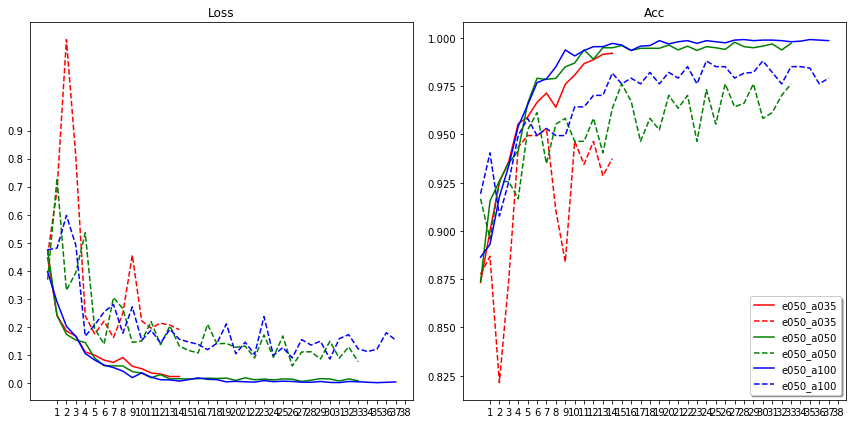

In [10]:
plot_train_history(exps, EPOCHS)

In [11]:
for exp in exps.keys():
    print('### %s:' % exp)
    H5FILE = H5FILE_FORMAT % exp
    model = keras.models.load_model(H5FILE)
    predict_val = model.predict_generator(get_val_gen(df_val, BATCH_SIZE), steps=np.ceil(df_val.shape[0]/BATCH_SIZE))
    make_validation(df_val['category'].replace(label_map).to_numpy(), predict_val, label_map[PREDICT_CATEGORY])
    predict_test = model.predict_generator(
        get_test_gen(df_test, BATCH_SIZE), 
        steps=np.ceil(df_test.shape[0]/BATCH_SIZE))
    df_out = pd.DataFrame()
    df_out['ID'] = df_test['filename'].apply(lambda fn: fn.split('.')[0])
    df_out['Predicted'] = predict_test[:, label_map[PREDICT_CATEGORY]]
    df_out.to_csv(OUTFILE_FORMAT % exp, index=False)
    print()

### e050_a035:
Found 400 images belonging to 2 classes.
Validation AUC: 0.458, Accuracy: 0.540
Found 400 images.

### e050_a050:
Found 400 images belonging to 2 classes.
Validation AUC: 0.532, Accuracy: 0.477
Found 400 images.

### e050_a100:
Found 400 images belonging to 2 classes.
Validation AUC: 0.562, Accuracy: 0.468
Found 400 images.

